# Setup

## Imports

In [1]:
%matplotlib inline
!pip install jmd_imagescraper
from jmd_imagescraper.core import *
from jmd_imagescraper.imagecleaner import *
from pathlib import Path
! pip install torch_utils

%config InlineBackend.figure_format = 'retina'

import os
import sys
import matplotlib.pyplot as plt
import pandas as pd
from pandas.core.common import flatten
import copy
import numpy as np
import random
import os

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

import glob
from tqdm import tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for torch-utils: filename=torch_utils-0.1.2-py3-none-any.whl size=6202 sha256=a3bd9750c1ca4e21cda60441d5e56df17bc3fb7a1bf524e4dab60ed4a24ad3bf
  Stored in directory: /root/.cache/pip/wheels/5d/c0/1d/a539c1c2a4d41c5d7109899289cded24fe1320b6a6c7b02a4c
Successfully built torch-utils


## Google Login

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
#%cd gdrive/MyDrive/Colab\ Notebooks/map_icon_finder
#root_path = Path().cwd()/"images"
root_path = '/content/images/'
%mkdir '/content/images/'
%ls

gdrive/  images/  sample_data/


Datasets & DataLoaders
===================


Code for processing data samples can get messy and hard to maintain; we ideally want our dataset code
to be decoupled from our model training code for better readability and modularity.
PyTorch provides two data primitives: ``torch.utils.data.DataLoader`` and ``torch.utils.data.Dataset``
that allow you to use pre-loaded datasets as well as your own data.
``Dataset`` stores the samples and their corresponding labels, and ``DataLoader`` wraps an iterable around
the ``Dataset`` to enable easy access to the samples.

PyTorch domain libraries provide a number of pre-loaded datasets (such as FashionMNIST) that
subclass ``torch.utils.data.Dataset`` and implement functions specific to the particular data.
They can be used to prototype and benchmark your model. You can find them
here: `Image Datasets <https://pytorch.org/vision/stable/datasets.html>`_,
`Text Datasets  <https://pytorch.org/text/stable/datasets.html>`_, and
`Audio Datasets <https://pytorch.org/audio/stable/datasets.html>`_




Loading a Dataset
-------------------

Here is an example of how to load the `Fashion-MNIST <https://research.zalando.com/project/fashion_mnist/fashion_mnist/>`_ dataset from TorchVision.
Fashion-MNIST is a dataset of Zalando’s article images consisting of 60,000 training examples and 10,000 test examples.
Each example comprises a 28×28 grayscale image and an associated label from one of 10 classes.

We load the `FashionMNIST Dataset <https://pytorch.org/vision/stable/datasets.html#fashion-mnist>`_ with the following parameters:
 - ``root`` is the path where the train/test data is stored,
 - ``train`` specifies training or test dataset,
 - ``download=True`` downloads the data from the internet if it's not available at ``root``.
 - ``transform`` and ``target_transform`` specify the feature and label transformations



In [4]:
# Download Fashion MNIST Dataset from torchvision
"""training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)"""

# Download ZIP From Google Drive
os.chdir(root_path)
!gdown 1tPg7SXhsYSpX48r3z9VdknPbm0AJqttZ
!unzip -o images.zip
%ls
!gdown 10PQu-cvWaJXHL2WPS_xH7xff0olIHMFW
!unzip -o test_images.zip
print("root path: ", root_path)
%ls



# Compress all images to single zip file
#!zip -r /content/ImagesfromColab.zip /content/images

Downloading...
From: https://drive.google.com/uc?id=1tPg7SXhsYSpX48r3z9VdknPbm0AJqttZ
To: /content/images/images.zip
100% 1.88M/1.88M [00:00<00:00, 158MB/s]
Archive:  images.zip
  inflating: green/green-001.png     
  inflating: green/green-002.png     
  inflating: green/green-003.png     
  inflating: green/green-004.png     
  inflating: green/green-005.png     
  inflating: green/green-006.png     
  inflating: green/green-007.png     
  inflating: green/green-008.png     
 extracting: other/anchor-1.png      
  inflating: other/anchor-white.png  
  inflating: other/anchor-yellow.png  
  inflating: other/blue-arrow.png    
  inflating: other/blue-circle.png   
  inflating: other/dots.png          
  inflating: other/gray-arrow.png    
  inflating: other/gray-circle.png   
  inflating: other/green-funnel.png  
  inflating: other/helicopter.png    
  inflating: other/lighthouse.png    
  inflating: other/marker.png        
  inflating: other/orange-arrow.png  
  inflating: other/oran

Download images

In [5]:
#duckduckgo_search(root_path, "Cats", "cute kittens", max_results=20)

## Create Train, Validate, and Test Sets

In [6]:
####################################################
#       Create Train, Valid and Test sets
####################################################
train_data_path = root_path # images\train folder
test_data_path = root_path + 'test_images' # images\test folder

train_image_paths = [] #to store image paths in list
classes = [] #to store class values
train_image_paths_v2 = []
classes_v2 = []

# get all the paths from train_data_path and append image paths and class to to respective lists
# eg. train path-> 'images/train/26.Pont_du_Gard/4321ee6695c23c7b.jpg'
# eg. class -> 26.Pont_du_Gard
for data_path in glob.glob(train_data_path + '/*'):
    classes.append(data_path.split('/')[-1]) 
    train_image_paths.append(glob.glob(data_path + '/*'))

# only keep specific classes
classes_v2.append(classes[ classes.index("green")] )
classes_v2.append(classes[ classes.index("red")] )
train_image_paths_v2.append( train_image_paths[ classes.index("green") ] )
train_image_paths_v2.append( train_image_paths[ classes.index("red") ] )

# overwrite original vars
train_image_paths = train_image_paths_v2
classes = classes_v2

# output train set
print("Create Train Set")
print("classes len: ", len(classes))
print("classes: ", classes)
print("train_image_paths len: ", len(train_image_paths))
print("train_image_paths: ", train_image_paths)
print("")

train_image_paths = list(flatten(train_image_paths))
random.shuffle(train_image_paths)

print('train_image_path example: ', train_image_paths[0])

# split train valid from train paths (80,20)
train_image_paths, valid_image_paths = train_image_paths[:int(0.8*len(train_image_paths))], train_image_paths[int(0.8*len(train_image_paths)):] 

# create the test_image_paths
test_image_paths = []
for data_path in glob.glob(test_data_path + '/*'):
    #print(data_path)
    test_image_paths.append(data_path)
    #test_image_paths.append(glob.glob(data_path + '/*'))

test_image_paths = list(flatten(test_image_paths))

print("\nTrain size: {}\nValid size: {}\nTest size: {}".format(len(train_image_paths), len(valid_image_paths), len(test_image_paths)))

Create Train Set
classes len:  2
classes:  ['green', 'red']
train_image_paths len:  2
train_image_paths:  [['/content/images/green/green-001.png', '/content/images/green/green-002.png', '/content/images/green/green-008.png', '/content/images/green/green-004.png', '/content/images/green/green-005.png', '/content/images/green/green-006.png', '/content/images/green/green-003.png', '/content/images/green/green-007.png'], ['/content/images/red/red-004.png', '/content/images/red/red-005.png', '/content/images/red/red-006.png', '/content/images/red/red-003.png', '/content/images/red/red-008.png', '/content/images/red/red-001.png', '/content/images/red/red-002.png', '/content/images/red/red-007.png']]

train_image_path example:  /content/images/red/red-007.png

Train size: 12
Valid size: 4
Test size: 5


## Create index_to_class and class_to_index dictionaries

In [7]:
idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}

print(idx_to_class)
print(class_to_idx)

{0: 'green', 1: 'red'}
{'green': 0, 'red': 1}


Creating a Custom Dataset for your files
---------------------------------------------------

A custom Dataset class must implement three functions: `__init__`, `__len__`, and `__getitem__`.
Take a look at this implementation; the FashionMNIST images are stored
in a directory ``img_dir``, and their labels are stored separately in a CSV file ``annotations_file``.

In the next sections, we'll break down what's happening in each of these functions.



In [8]:
#######################################################
#               Define Transforms
#######################################################

#To define an augmentation pipeline, you need to create an instance of the Compose class.
#As an argument to the Compose class, you need to pass a list of augmentations you want to apply. 
#A call to Compose will return a transform function that will perform image augmentation.
#(https://albumentations.ai/docs/getting_started/image_augmentation/)

# A.CenterCrop(height=h, width=w) - all images need to be larger than the dimensions specified

train_transforms = A.Compose(
    [
        #A.SmallestMaxSize(max_size=350),
        #A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=360, p=0.5),
        #A.RandomCrop(height=256, width=256),
        A.CenterCrop(height=100, width=100),
        #A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        #A.RandomBrightnessContrast(p=0.5),
        #A.MultiplicativeNoise(multiplier=[0.5,2], per_channel=True, p=0.2),
        #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        #A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
        #A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
        ToTensorV2(),
    ]
)

test_transforms = A.Compose(
    [
        #A.SmallestMaxSize(max_size=350),
        #A.CenterCrop(height=256, width=256),
        #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.CenterCrop(height=100, width=100),
        ToTensorV2(),
    ]
)

#######################################################
#               Define Dataset Class
#######################################################
class CustomImageDataset(Dataset):
    """
    # The __init__ function is run once when instantiating the Dataset object. 
    # We initialize the directory containing the images, the annotations file, and both transforms.
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    # The __len__ function returns the number of samples in our dataset.
    def __len__(self):
        return len(self.img_labels)

    # The __getitem__ function loads and returns a sample from the dataset at the given index ``idx``.
    # Based on the index, it identifies the image's location on disk, converts that to a tensor using ``read_image``, retrieves the
    # corresponding label from the csv data in ``self.img_labels``, calls the transform functions on them (if applicable), and returns the
    # tensor image and corresponding label in a tuple.
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
    """
    def __init__(self, image_paths, transform=False):
        self.image_paths = image_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        label = image_filepath.split('/')[-2]
        label = class_to_idx[label]
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        
        return image, label

#######################################################
#                  Create Dataset
#######################################################
train_dataset = CustomImageDataset(train_image_paths, train_transforms)
valid_dataset = CustomImageDataset(valid_image_paths, test_transforms) #test transforms are applied
test_dataset = CustomImageDataset(test_image_paths, test_transforms)

## Iterating and Visualizing the Dataset

**`Datasets` need to exist before this step!**

We can index ``Datasets`` manually like a list: ``training_data[index]``.
We use ``matplotlib`` to visualize some samples in our training data.



In [9]:
#display_image_cleaner(root_path) # can only display JPGs currently

image shape:  torch.Size([100, 100, 3])
label shape:  1
image shape:  torch.Size([100, 100, 3])
label shape:  0
image shape:  torch.Size([100, 100, 3])
label shape:  0
image shape:  torch.Size([100, 100, 3])
label shape:  1
image shape:  torch.Size([100, 100, 3])
label shape:  1
image shape:  torch.Size([100, 100, 3])
label shape:  1
image shape:  torch.Size([100, 100, 3])
label shape:  0
image shape:  torch.Size([100, 100, 3])
label shape:  1
image shape:  torch.Size([100, 100, 3])
label shape:  1


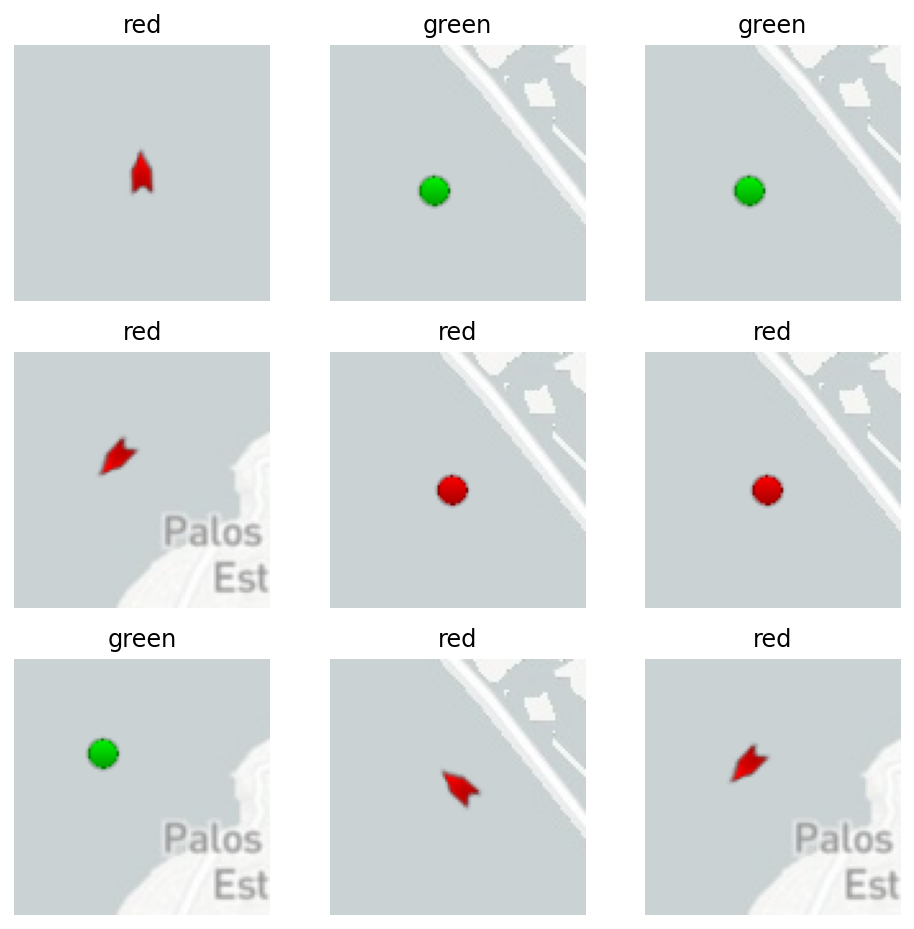

In [10]:
"""labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()"""


figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
  sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
  img, label = train_dataset[sample_idx]
  figure.add_subplot(rows, cols, i)
  plt.title(idx_to_class[label]) # use "idx_to_class" dictionary
  img = img.squeeze().permute(1,2,0)
  print("image shape: ", img.shape)
  print("label shape: ", label)
  plt.axis("off")
  plt.imshow(img)
plt.show()

Preparing your data for training with DataLoaders
-------------------------------------------------
The ``Dataset`` retrieves our dataset's features and labels one sample at a time. While training a model, we typically want to
pass samples in "minibatches", reshuffle the data at every epoch to reduce model overfitting, and use Python's ``multiprocessing`` to
speed up data retrieval.

``DataLoader`` is an iterable that abstracts this complexity for us in an easy API.



In [11]:
#######################################################
#                  Define Dataloaders
#######################################################
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

Iterate through the DataLoader
--------------------------

We have loaded that dataset into the ``DataLoader`` and can iterate through the dataset as needed.
Each iteration below returns a batch of ``train_features`` and ``train_labels`` (containing ``batch_size=64`` features and labels respectively).
Because we specified ``shuffle=True``, after we iterate over all batches the data is shuffled (for finer-grained control over
the data loading order, take a look at [Samplers](https://pytorch.org/docs/stable/data.html#data-loading-order-and-sampler).



Feature batch shape: torch.Size([12, 3, 100, 100])
Labels batch shape: torch.Size([12])


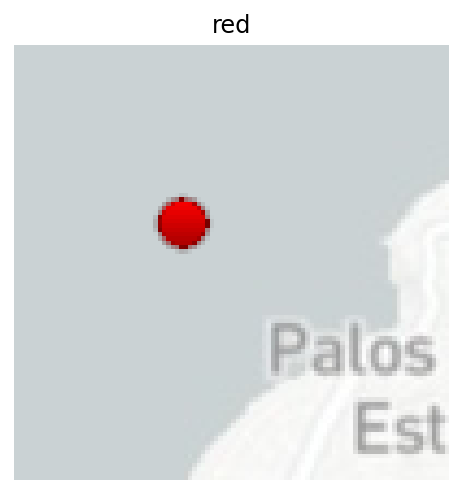

In [37]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
img = img.squeeze().permute(1,2,0)
label = train_labels[0] 
lbl = int(f"{label}")
lbl_name = idx_to_class[lbl]
plt.axis("off")
plt.title(lbl_name)
plt.imshow(img, cmap="gray")
plt.show()

# Train